[View in Colaboratory](https://colab.research.google.com/github/JozeeLin/google-tensorflow-exercise/blob/master/first_steps_with_tensor_flow.ipynb)

学习目标:
- 学习基本的TensorFlow概念
- 在TensorFlow中使用LinearRegressor类并基于单个输入特征预测各城市街区的房屋价值中位数
- 使用均方根误差评估模型预测准确率
- 通过调整模型的超参数提高模型准确率

In [0]:
import math
from IPython import display
from matplotlib import cm #colormap
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

### 加载数据集

In [0]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv",sep=',')

数据进行随机化处理，以确保不会出现任何病态排序结果(可能会损害随机梯度下降法的效果)。此外，将median_house_value调整为以千为单位，这样，模型就能够以常用范围内的学习速率较为轻松地学习这些数据。

In [4]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index)) #对样本进行随机化处理
california_housing_dataframe['median_house_value'] /= 1000.0 #以千为单位
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
15981,-122.4,37.8,52.0,1580.0,470.0,714.0,448.0,3.2,500.0
12498,-121.6,36.7,12.0,512.0,144.0,767.0,149.0,2.3,72.9
5423,-118.2,34.6,5.0,7294.0,1139.0,3123.0,930.0,5.0,154.1
14307,-122.1,40.0,26.0,633.0,129.0,305.0,140.0,2.2,72.7
690,-117.0,33.1,22.0,2427.0,390.0,1099.0,362.0,5.2,167.5
...,...,...,...,...,...,...,...,...,...
10153,-119.8,34.4,31.0,798.0,346.0,699.0,301.0,2.1,205.0
16976,-124.2,40.8,13.0,2171.0,339.0,951.0,353.0,4.9,116.1
11285,-121.1,37.7,40.0,1126.0,220.0,667.0,235.0,3.3,125.9
10415,-120.3,39.3,24.0,6012.0,1227.0,780.0,358.0,3.0,122.1


## 检查数据
输出各列的一些实用统计信息快速摘要:样本数、均值、标准偏差、最大值、最小值和各种分位数|

In [5]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


## 构建第一个模型
预测median_house_value，total_rooms作为输入特征
**注意**:我们使用的是城市街区级别的数据，因此该特征表示相应街区的房间总数。
  
这里使用TensorFlow Estimator API提供的LinearRegressor接口。此API负责处理大量低级别模型搭建工作，并会提供执行模型训练、评估和推理的便利方法。

### 第一步：定义特征并配置特征列
为各个特征指定数据类型。数据类型主要有两种:
- 分类数据：一种文字数据
- 数值数据：一种数字(整数或浮点数)数据以及您希望视为数字的数据。（有时可能需要将数值数据视为分类数据）

在TensorFlow中，我们使用一种称为“特征列”的结构来表示特征的数据类型。特征列仅存储对特征数据的描述;不包含特征数据本身。

In [0]:
#获取输入特征total_rooms，并指定特征列的数据类型为数值类型
my_feature = california_housing_dataframe[['total_rooms']]
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

### 第2步：定义目标 median_house_value

In [0]:
targets = california_housing_dataframe['median_house_value']

### 第3步:配置LinearRegressor
使用GradientDescentOptimizer(它会实现小批量随机梯度下降法(SGD))训练该模型
learning_rate参数可控制梯度步长的大小。<br>
**注意**：为了安全起见，我们还会通过clip_gradients_by_norm将梯度裁剪应用到我们的优化器。梯度裁剪可确保梯度大小在训练期间不会变的过大，梯度过大会导致梯度下降法失败。
<br>
**梯度裁剪**:在应用梯度值之前先设置其上限。梯度裁剪有助于确保数值稳定性以及防止梯度爆炸。

In [0]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)

linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)

### 第4步：定义输入函数
定义数据预处理函数，以及在模型训练期间如何批处理、随机处理和重复数据 <br>
首先，将pandas特征数据转换成NumPy数组字典。<br>
然后，我们可以使用TensorFlow Dataset API根据我们的数据构建Dataset对象，并将数据拆分成大小为batch_size的多批数据，以按照指定周期数(num_epochs)进行重复 <br>
**注意**:将默认值num_epochs=None传递到repeat()，输入数据会无期限重复。<br>
然后，如果shuffle设置为True，则我们会对数据进行随机处理，以便数据在训练期间以随机方式传递到模型。buffer_size参数会指定shuffle将从中随机抽样的数据集的大小。

In [0]:
def my_input_fn(feature, targets, batch_size=1, shuffle=True, num_epochs=None):
  #将pandas特征数据转换成NumPy数组字典
  features = {key:np.array(value) for key,value in dict(feature).items()}
  #将数据拆分成大小为batch_size的多批数据，以按照指定周期数(num_epochs)进行重复
  ds = Dataset.from_tensor_slices((features, targets)) #warning: 2GB limit
  ds = ds.batch(batch_size).repeat(num_epochs)
  #是否对数据进行随机处理，buffer_size为随机抽样的数据集大小
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)
    
  #为数据集构建一个迭代器
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

**注意：**后面的练习中，我们会继续使用此输入函数。有关输入函数和DataSet API的更详细的文档。请参阅[TensorFlow编程人员指南](https://www.tensorflow.org/programmers_guide/datasets)
<br>
### 第5步：训练模型
在linear_regressor上调用train()来训练模型。将my_input_fn封装在lambda中，以便可以将my_feature和target作为参数传入<br>
(有关详情，请参阅此[TensorFlow输入函数教程](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model)) <br>
首先，训练100步

In [0]:
_ = linear_regressor.train(input_fn = lambda:my_input_fn(my_feature, targets), steps=100)

### 第6步:评估模型
看看模型在训练期间与这些数据的拟合情况 <br>
**注意：**训练误差可以衡量您的模型与训练数据的拟合情况，但并不能衡量模型泛化到新数据的效果。在后面的练习中，将探索如何拆分数据以评估模型的泛化能力。

In [12]:
#need to repeat or shuffle the data here
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

#call predict() on the linear_regressor to make predictions
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

#format predictions as a numpy array, so we can calculate error metrics
predictions = np.array([item['predictions'][0] for item in predictions])

#print mean squared error and root mean squared error
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error(on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error(on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error(on training data): 56367.025
Root Mean Squared Error(on training data): 237.417


由于均方误差(MSE)很难解读，因此我们经常查看的是均方根误差(RMSE).RMSE的一个很好的特性是，它可以在与原目标相同的规模下解读。
我们来比较一下RMSE与目标最大值和最小值的差值:

In [13]:
min_house_value = california_housing_dataframe['median_house_value'].min()
max_house_value = california_housing_dataframe['median_house_value'].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


上述误差跨越目标值的近一半范围，可以进一步缩小误差。<br>
首先，我们可以了解一下根据总体摘要统计信息，预测和目标的符合情况

In [14]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


平均值与模型的RMSE相比情况如何？各种分位数呢？
<br>
还可以将数据和学到的线可视化。
<br>
单个特征的线性回归可绘制成一条将输入x映射到输出y的线
<br>
首先，将获得均匀分布的随机数据样本，以便绘制可辨的散点图

In [0]:
sample = california_housing_dataframe.sample(n=300)

然后，根据模型的偏差项和特征项权重绘制学到的线，并绘制散点图。该线会以红色显示。

In [0]:
#get the min and max total_rooms values
x_0 = sample['total_rooms'].min()
x_1 = sample['total_rooms'].max()

#Retrieve the final weight and bias generated during training
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

In [0]:
#get the predicted median_house_values for the min and max total_rooms values
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

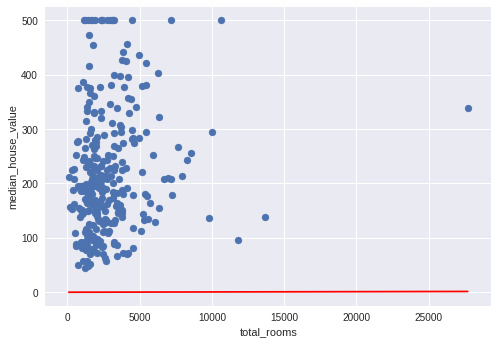

In [19]:
#plot our regression line from (x_0,y_0) to (x_1, y_1).
plt.plot([x_0,x_1],[y_0,y_1],c='r')
#label the graph axes
plt.ylabel('median_house_value')
plt.xlabel('total_rooms')
#plot a scatter plot from data sample
plt.scatter(sample['total_rooms'], sample['median_house_value'])
#display graph
plt.show()

这条初始线看起来与目标相差很大。回想一下之前输出的摘要统计信息，并看到其中蕴含的相同信息
<br>
综上所述，这些初始健全性检查提示我们需要可以找到更好的线。
## 调整模型超参数
对于本练习，为方便起见，我们已将上述所有代码放入一个函数中。使用不同的参数调用该函数，以了解相应效果。<br>
在10个等分的时间段内使用此函数，以便观察模型在每个时间段的改善情况。<br>
对于每个时间段，我们都会计算训练损失并绘制相应图表。用于判断模型收敛时间 <br>
此外，我们还会绘制模型随着时间的推移学习的特征权重和偏差项值得曲线图。你还可以通过这种方式查看模型的收敛效果。

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 236.32
  period 01 : 235.11
  period 02 : 233.90
  period 03 : 232.70
  period 04 : 231.50
  period 05 : 230.31
  period 06 : 229.13
  period 07 : 227.96
  period 08 : 226.79
  period 09 : 225.63
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 225.63


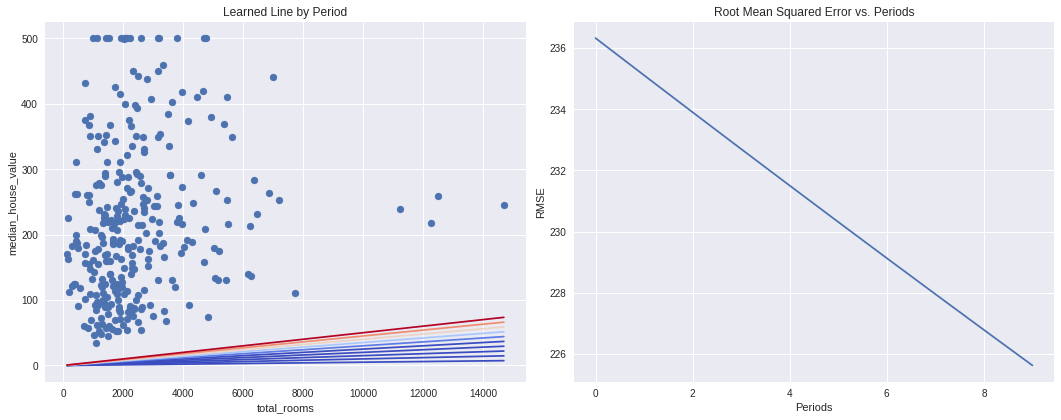

In [22]:
train_model(0.00001, 100, 1, input_feature="total_rooms")

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 194.62
  period 04 : 186.60
  period 05 : 180.53
  period 06 : 175.22
  period 07 : 171.07
  period 08 : 168.50
  period 09 : 167.53
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,115.3,207.3
std,95.0,116.0
min,0.1,15.0
25%,63.7,119.4
50%,92.7,180.4
75%,137.4,265.0
max,1654.1,500.0


Final RMSE (on training data): 167.53


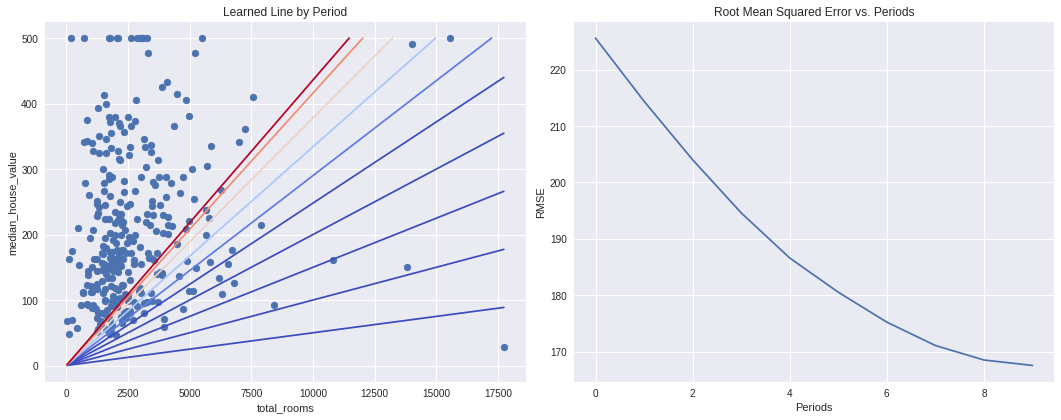

In [23]:
train_model(0.00002, 500, 5)

### 模型调参的经验法则:
- 训练误差应该稳步减小，刚开始是急剧减小，最终应随着训练收敛达到平稳状态
- 如果训练尚未收敛，尝试运行更长的时间
- 如果训练误差减小速度过慢，则提高学习速率也许有助于加快其减小速度
  - 但有时如果学习速率过高，训练误差的减小速度反而会变慢
- 如果训练误差变化很大，尝试降低学习速率
  - 较低的学习速率和较大的步数/较大的批量大小通常是不错的组合
- 批量大小过小也会导致不稳定情况。不妨先尝试100或1000等较大的值，然后逐步减小值得大小，知道出现性能降低的情况

## 任务2：尝试其他特征
使用population特征替换total_rooms特征，看看能否取得更好的效果。

Training model...
RMSE (on training data):
  period 00 : 236.92
  period 01 : 236.31
  period 02 : 235.70
  period 03 : 235.09
  period 04 : 234.48
  period 05 : 233.88
  period 06 : 233.28
  period 07 : 232.68
  period 08 : 232.08
  period 09 : 231.48
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,7.1,207.3
std,5.7,116.0
min,0.0,15.0
25%,4.0,119.4
50%,5.8,180.4
75%,8.6,265.0
max,178.4,500.0


Final RMSE (on training data): 231.48


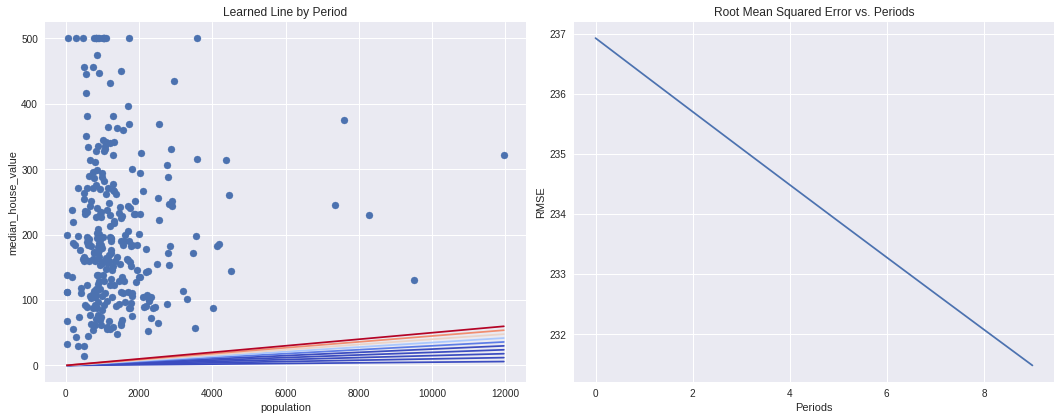

In [24]:
train_model(0.00001, 100, 1, input_feature="population")

监督机器学习算法的三项基本假设：
- 我们从分布中随机抽取独立同分布的样本
- 分布式平稳的：分布不会随时间发生变化
- 我们始终从同一分布中抽取样本:包括训练集、验证集和测试集